**Semi-Supervised Example**

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [17]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import numpy as np
import pandas as pd

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/unsupervised_learning` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Using Clustering for Semi-Supervised Learning

Another use case for clustering is semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.25, random_state=182)

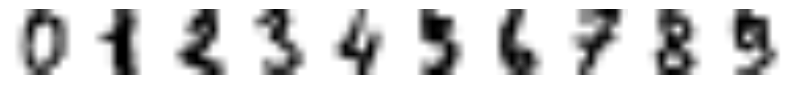

In [7]:
plt.figure(figsize=(10, 20))
for index, X_representative_digit in enumerate(X_digits[:10]):
    plt.subplot(10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_plot", tight_layout=False)
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression
# extra code – measure the accuracy when we use the whole training set
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9555555555555556

In [18]:
pd.DataFrame(y_train).value_counts(normalize=True)

0
1    0.105419
2    0.103935
7    0.103935
3    0.101707
5    0.098738
4    0.097996
6    0.097996
8    0.097996
9    0.097996
0    0.094284
Name: proportion, dtype: float64

In [20]:
pd.DataFrame(y_test).value_counts(normalize=True)

0
0    0.113333
4    0.108889
5    0.108889
6    0.108889
9    0.106667
3    0.102222
8    0.093333
1    0.088889
7    0.086667
2    0.082222
Name: proportion, dtype: float64

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [9]:
from sklearn.cluster import KMeans
k = 70
kmeans = KMeans(n_clusters=k, n_init=10, random_state=777)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

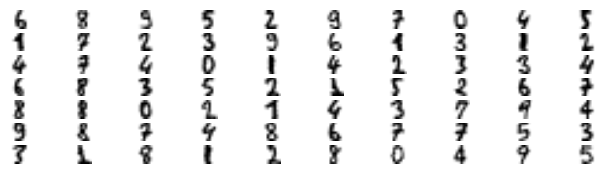

In [10]:
# extra code – this cell generates and saves Figure 9–13

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_plot", tight_layout=False)
plt.show()

In [11]:
y_representative_digits = y_train[representative_digit_idx]

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [12]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [13]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [14]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=10000)

In [15]:
log_reg.score(X_test, y_test)

0.9577777777777777

Wow, another accuracy boost! We have even slightly surpassed the performance we got by training on the fully labeled training set!

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.